In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from collab2.foraging.toolkit import (
    _generate_next_step_score,
    dataObject,
    generate_local_windows,
    generate_pairwiseCopying,
    generate_vicsek,
    plot_predictor,
    rescale_to_grid,
    subsample_frames_constant_frame_rate,
)

In [2]:
# load data
fish_data = pd.read_csv("4wpf_test.csv")
gridMin = 0
gridMax = 300
grid_size = 50
fps = 121

# scaling and subsampling
fishDF_scaled = rescale_to_grid(
    fish_data, size=grid_size, gridMin=gridMin, gridMax=gridMax
)
fishDF_scaled_subsampled = subsample_frames_constant_frame_rate(
    fishDF_scaled, frame_spacing=121, fps=fps
)

# create a test foragers object with 20 frames
num_frames = 10
foragers_object = dataObject(
    fishDF_scaled_subsampled.loc[fishDF_scaled_subsampled["time"] < num_frames],
    grid_size=grid_size,
)

# get local windows
local_windows_kwargs = {
    "window_size": 15,
    "sampling_fraction": 1,
    "skip_incomplete_frames": True,
}

foragers_object.local_windows_kwargs = local_windows_kwargs

local_windows = generate_local_windows(foragers_object)
foragers_object.local_windows = local_windows

original_frames: 18739
original_shape: (74956, 5)
resulting_frames: 155
resulting_shape: (620, 5)
new frame-rate =  1.00


/Users/Admin/Repositories/collab-creatures/collab2/foraging/toolkit/utils.py:36: UserWarning:  Nan values in data.
                Specify handling of missing data using `skip_incomplete_frames` argument to `generate_all_predictors`
  warnings.warn(


# There are a number of ways of defining / normalizing a score for `distance_to_next_pos`

1. `scored_raw_distance_to_next_pos` = 1 - (`raw_distance_to_next_pos`/ 2*`window_size`)^2

This version is biased towards larger values, since 2*`window_size` is much larger than the actual distances obtained (~ `window_size`)

2. `rescaled_scored_raw_distance_to_next_pos` = `scored_raw_distance_to_next_pos` - min(`scored_raw_distance_to_next_pos`) / (max(`scored_raw_distance_to_next_pos`) - min(`scored_raw_distance_to_next_pos`))

This is spread across (0,1) with a slight bias to higher values

3. `scored_rescaled_distance_to_next_pos` = 1 - `rescaled_distance_to_next_pos` where

`rescaled_distance_to_next_pos` = (`raw_distance_to_next_pos` - min(`raw_distance_to_next_pos`)) / (max(`raw_distance_to_next_pos`) - min(`raw_distance_to_next_pos`))

This is spread across (0,1) with a slight bias towards smaller values

# computing all the scores

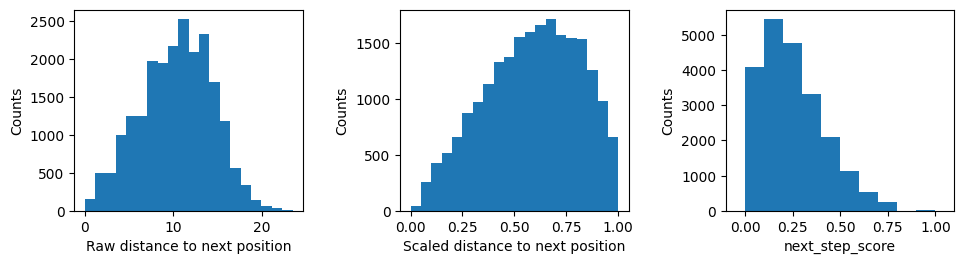

In [3]:
next_step_score = _generate_next_step_score(
    foragers_object.foragers, local_windows, n=0.5
)
# convert to DF
next_step_scoreDF = pd.concat([pd.concat(dfs) for dfs in next_step_score])

# plot distribution of scores
fig, ax = plt.subplots(1,3, figsize=(10, 3))

ax[0].hist(next_step_scoreDF["distance_to_next_step"], bins=20)
ax[0].set_xlabel("Raw distance to next position")
ax[0].set_ylabel("Counts")

ax[1].hist(next_step_scoreDF["scaled_distance_to_next_step"], bins=20)
ax[1].set_xlabel("Scaled distance to next position")
ax[1].set_ylabel("Counts")

ax[2].hist(next_step_scoreDF["next_step_score"])
ax[2].set_xlabel("next_step_score")
ax[2].set_xlim([-0.1, 1.1])
ax[2].set_ylabel("Counts")

fig.tight_layout(pad=2)

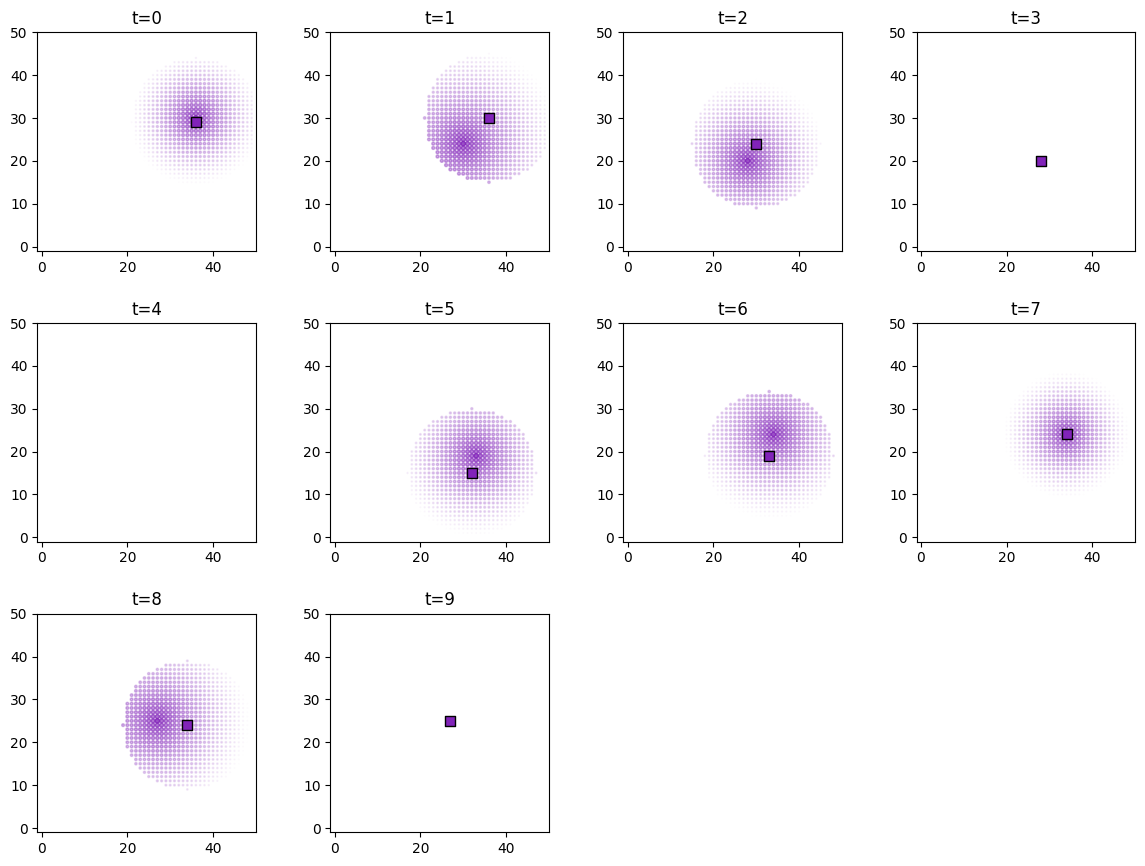

In [4]:
# visualize on the grid
plot_predictor(
    foragers_object.foragers,
    next_step_score,
    "next_step_score",
    [3],
    range(num_frames),
    grid_size,
    size_multiplier=10,
    random_state=99,
)

# Plot against predictors 

In [5]:
# choose predictor kwargs and add to object
predictor_kwargs = {
    "vicsek": {
        "interaction_length": grid_size / 3,
        "interaction_constraint": None,
        "interaction_constraint_params": None,
        "dt": 1,
        "sigma_v": 3,
        "sigma_t": 0.3,
    },
    "pairwiseCopying": {
        "interaction_length": grid_size / 3,
        "interaction_constraint": None,
        "interaction_constraint_params": None,
        "dt": 1,
        "sigma_v": 3,
        "sigma_t": 0.3,
    },
}
foragers_object.predictor_kwargs = predictor_kwargs

# generate predictors
vicsek_predictor = generate_vicsek(foragers_object, "vicsek")
pairwiseCopying_predictor = generate_pairwiseCopying(foragers_object, "pairwiseCopying")

# convert to DFs
vicsek_predictorDF = pd.concat([pd.concat(dfs) for dfs in vicsek_predictor])
pairwiseCopying_predictorDF = pd.concat(
    [pd.concat(dfs) for dfs in pairwiseCopying_predictor]
)

/Users/Admin/Repositories/collab-creatures/collab2/foraging/toolkit/velocity.py:181: UserWarning: Dropped 7/36 instances from vicsek predictor calculation
            due to invalid velocity values
  warnings.warn(
/Users/Admin/Repositories/collab-creatures/collab2/foraging/toolkit/velocity.py:31: UserWarning: Using existing velocity data.
                Delete corresponding columns from foragersDF to re-calculate velocity values.
  warnings.warn(
/Users/Admin/Repositories/collab-creatures/collab2/foraging/toolkit/velocity.py:181: UserWarning: Dropped 7/36 instances from pairwiseCopying predictor calculation
            due to invalid velocity values
  warnings.warn(


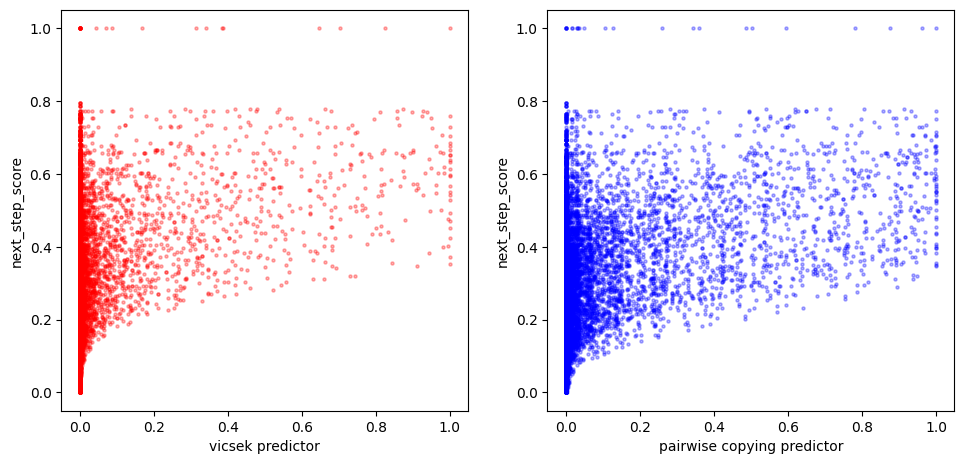

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(
    vicsek_predictorDF["vicsek"],
    next_step_scoreDF["next_step_score"],
    s=5,
    alpha=0.3,
    color="r",
)
ax[0].set_ylabel("next_step_score")
ax[0].set_xlabel("vicsek predictor")

ax[1].scatter(
    pairwiseCopying_predictorDF["pairwiseCopying"],
    next_step_scoreDF["next_step_score"],
    s=5,
    alpha=0.3,
    color="b",
)
ax[1].set_ylabel("next_step_score")
ax[1].set_xlabel("pairwise copying predictor")


fig.tight_layout(pad=2)

plt.show()